<a href="https://colab.research.google.com/github/VictorNiaussat/DeepLearningAction/blob/main/Time_series_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time-series analysis (LSTM, 1D-CNN, 2D-CNN, …)
The aim of this lab (TP) is to a classification system of Human Activity Recognition (HAR).
The data used for classification is provided by the Wireless Sensor Data Mining (WISDM) Lab and can be downloaded directly from the course platform “actitracker_raw.txt”. It consists of 1,098,207 examples of various physical activities (sampled at 20Hz) with 6 attributes: user,activity,timestamp,x-acceleration,y-acceleration,z-acceleration.
The activities include: Walking, Jogging, Upstairs, Downstairs, Sitting, Standing. 

This data comes from the [University of Fordham](https://www.cis.fordham.edu/wisdm/dataset.php) and represents the accelerometer data while doing various activities. The aim is to determine which activity is done by analysing the sequence. According to the sources, the number of samples is equal to 1,098,207 divided in 6 classes :

*   Walking: 424,400 (38.6%)
*   Jogging: 342,177 (31.2%)
*   Upstairs: 122,869 (11.2%)
*   Downstairs: 100,427 (9.1%)
*   Sitting: 59,939 (5.5%)
*   Standing: 48,395 (4.4%)


Starting by downloading the data and aploading here:
https://drive.google.com/file/d/1eFEItgFg83sV9nZUI5MI5dV2D6OxPvKt/view?usp=sharing

We can use pandas to handle the time series. While displaying the values, we observe z-axis is not in the correct format because of the semicolon. we have to convert this data to numerical values. we can notice the presence of a NaN value so it's possible to use linear interpolation replace it.

In [ ]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from zipfile import ZipFile
from google.colab.patches import cv2_imshow
import tensorflow as tf
from tensorflow.keras import models,optimizers,layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.callbacks import TensorBoard

Start by upload the data:

In order to show how the x-acceleration was changing with time (or more accurately - at each timestep) for each one of these activities, you can use this function:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plotAxis(axis,x,y,title):
    axis.plot(x,y)
    axis.set_title(title)
    axis.xaxis.set_visible(False)
    axis.set_ylim([min(y)-np.std(y),max(y)+np.std(y)])
    axis.set_xlim([min(x),max(x)])
    axis.grid(True)

    
def plotActivity(activity,data):
    fig,(ax0,ax1,ax2) = plt.subplots(nrows=3, figsize=(15,10),sharex=True)
    plotAxis(ax0,data['timestamp'],data['x-axis'],'x-axis')
    plotAxis(ax1,data['timestamp'],data['y-axis'],'y-axis')
    plotAxis(ax2,data['timestamp'],data['z-axis'],'z-axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.9)
    plt.show()

In [ ]:
def readData(filePath):
    # attributes of the dataset
    columnNames = ['user_id','activity','timestamp','x-axis','y-axis','z-axis']
    data = pd.read_csv(filePath,header = None, names=columnNames,na_values=';')
    return data


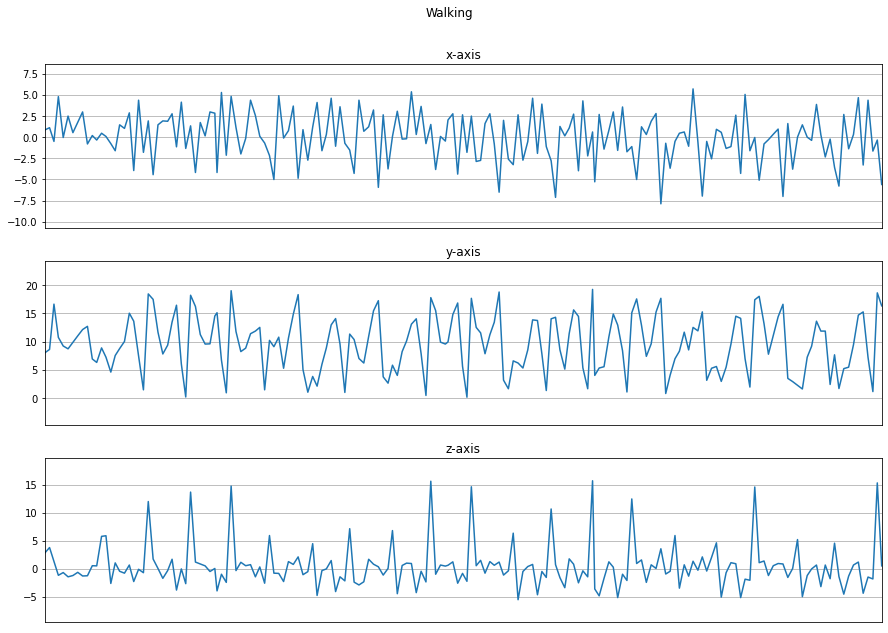

In [ ]:
dataset = readData('./actitracker_raw.txt')
for activity in np.unique(dataset['activity']):
  subset = dataset[dataset['activity']==activity][:180]
  subset=subset.interpolate()

plotActivity(activity,subset)

In order to feed the network with such temporal dependencies a sliding time window is used to extract separate data segments. The window width and the step size can be both adjusted and optimised for better accuracy. Each time step is associated with an activity label, so for each segment the most frequently appearing label is chosen. Here, the time segment or window width is chosen to be 90.

In [ ]:
def windows(data,size):
    start = 0
    while start< data.count():
        yield int(start), int(start + size)
        start+= (size/2)
# segmenting the time series
def segment_signal(data, window_size = 90):
    segments = np.empty((0,window_size,3))
    labels= np.empty((0))
    for (start, end) in windows(data['timestamp'],window_size):
        x = data['x-axis'][start:end]
        y = data['y-axis'][start:end]
        z = data['z-axis'][start:end]
        if(len(data['timestamp'][start:end])==window_size):
            segments = np.vstack([segments,np.dstack([x,y,z])])
            labels =np.append(labels,stats.mode(data['activity'][start:end])[0][0])
    return segments, labels


The data needs to be separated into features and labels and then further into training and test sets. Labels need to be one-hot encoded before feeding into the classifier. Then,split the data into train/test subset as 80%/20%: train (19522 sequences) and test (4881 sequences).


# 1. Convolutional Neural Network (2D CNN)

If you concatenate the time series columns, you obtain a 2D matrix, on which you can apply a 2D CNN based classification system. Because we want to apply a 2D CNN, it is necessary to add a dimension to our sequences.


In [ ]:
segments, labels = segment_signal(dataset) 
reshapedSeg = segments.reshape(segments.shape[0], segments.shape[1], segments.shape[2],1)

In [ ]:
print(np.array(segments).shape,np.array(labels).shape)

(24403, 90, 3) (24403,)


In [ ]:
# here your code


(19522, 90, 3) (19522,) (4881, 90, 3) (4881,)


2D CNN need also that the format of labels to be in one hot encoding labels. 

Here, you can propose a classification system based on a 2DCNN (you can find an example of a suggested model here:)

In [ ]:
# Here your model !!!

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 89, 2, 128)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 44, 1, 128)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 44, 1, 128)        0         
                                                                 
 flatten (Flatten)           (None, 5632)              0         
                                                                 
 dense (Dense)               (None, 128)               721024    
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                        

**Question 1**: Plot performance curves that show the evaluation of the CNN model.

**2.	Long-Short-Terms-Memory (LSTM)**


Configures an RNN as following:


In [ ]:
# your model here

print(RNN.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 90, 128)           67584     
                                                                 
 batch_normalization (BatchN  (None, 90, 128)          512       
 ormalization)                                                   
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 32)                4128      
                                                                 
 dropout_2 (Dropout)         (None, 32)               

**Question 2:** Plot performance curves that show the evaluation of the LSTM model and compare it to the previous CNN model.

**3. Convolutional Neural Network (1D CNN)**

1D CNN can perform activity recognition task from accelerometer data, such as if the person is standing, walking, jumping etc. This data has 2 dimensions. The first dimension is time-steps and other is the values of the acceleration in 3 axes. To add a Conv1D layer in keras for example:

In [ ]:
#from tensorflow.keras.layers import Conv1D
#model = models.Sequential()
#model.add(Conv1D(1, kernel_size=5, input_shape = (120, 3)))

In [ ]:
# here your model

print(model1D.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 86, 100)           1600      
                                                                 
 conv1d_1 (Conv1D)           (None, 82, 100)           50100     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 27, 100)          0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 23, 160)           80160     
                                                                 
 conv1d_3 (Conv1D)           (None, 19, 160)           128160    
                                                                 
 global_average_pooling1d (G  (None, 160)              0         
 lobalAveragePooling1D)                               

**Question 3:** Test the performance of this model and compare it to the previous models.

**Question 4:** Extend this model to the 3D Action dataset (based on seen at the last lab (TP GAN). 